# 数据集



## 数据集下载

关于本项目的数据集保存在[Kaggle](https://www.kaggle.com/)的[huizecai/mushroom](https://www.kaggle.com/datasets/huizecai/mushroom)中，下面的单元格可以直接下载该数据集并返回其路径。

In [ ]:
import os
import kagglehub

# 使用KaggleHub下载数据集
dataset_name = "huizecai/mushroom"
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:", path)

## 计算各蘑菇种类的图片数量

由于tensorflow中会有中文路径异常问题，该数据集中的各种类的文件夹名以“classXX”来命名，并用label.txt来与其中文名进行映射。

In [ ]:
dataset_path = path + '/archive/data'
label_path = path + '/archive/label.txt'

# 获取所有子目录（即蘑菇类别）
dir_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 读取 label.txt 并解析内容
categories = {}
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            category_name = parts[0]
            category_id = parts[1]
            categories[category_id] = category_name

# 统计每种类别的图像数量
category_counts = {}
for category_id in categories.keys():
    if category_id in dir_names:  # 确保目录存在
        category_dir = os.path.join(dataset_path, category_id)
        num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
        category_counts[categories[category_id]] = num_images

print("Category counts:", category_counts)

## 处理中文字体异常问题

在部分运行环境中，matplotlib可能会出现中文显示异常问题。此处将加载“SimHei”字体以解决该问题。

In [ ]:
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, fontManager

# 下载并保存字体文件
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"
font_name = "SimHei.ttf"
if not os.path.exists(font_name):
    urllib.request.urlretrieve(font_url, font_name)

# 注册字体文件到matplotlib的字体管理器
fontManager.addfont(font_name)

# 设置字体属性
font_prop = FontProperties(fname=font_name)

# 确保matplotlib使用正确的字体族名称
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 示例绘图
plt.title('这是一个标题', fontproperties=font_prop)
plt.xlabel('X轴标签', fontproperties=font_prop)
plt.ylabel('Y轴标签', fontproperties=font_prop)
plt.plot([0, 1, 2, 3], [0, 1, 4, 9])
plt.show()

## 绘制各种类图片数量的柱状图

In [ ]:
# 准备数据
categories_readable = list(category_counts.keys())
counts = list(category_counts.values())

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 绘制柱状图
bars = plt.barh(categories_readable, counts, color='skyblue')

# 添加数据标签
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, '%d' % int(width), va='center')

# 设置标题和标签
plt.title('各蘑菇种类的图片数量', fontsize=20)
plt.xlabel('图片数量', fontsize=16)
plt.ylabel('蘑菇种类', fontsize=16)

# 设置网格
plt.grid(axis='x', linestyle='--', alpha=0.7)
# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 训练准备工作

## 加载图像数据集

使用 TensorFlow 的 [image_dataset_from_directory](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en) 函数加载和准备图像数据集：


*   directory=dataset_path ：指定图像数据所在的路径。
*   image_size=(224, 224) ：指定每个图像的大小为224x224像素。
*   batch_size=32 ：指定每个批次包含32张图像。
*   validation_split=0.1 ：指定10%的数据作为验证集。
*   subset='both' ：指定同时返回训练集和验证集。
*   label_mode='categorical' ：指定标签模式为分类模式，返回one-hot编码的标签。
*   seed=21 ：设置随机种子以确保数据集的可重复性。



In [ ]:
import tensorflow as tf

# 加载和准备图像数据集
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.1,
    subset='both',
    label_mode='categorical',
    seed=21
)

## 计算训练集和验证集的各种类图片分布

In [ ]:
import numpy as np

# 获取类别名称
class_names = train_dataset.class_names

# 初始化字典用于存储每种类别的图像数量
train_category_counts = {name: 0 for name in categories.values()}
validation_category_counts = {name: 0 for name in categories.values()}

# 统计训练集中的图像数量
for images, labels in train_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        train_category_counts[categories[category_name]] += 1

# 统计验证集中的图像数量
for images, labels in validation_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        validation_category_counts[categories[category_name]] += 1


print("训练集类别图像数量统计:", train_category_counts)
print("验证集类别图像数量统计:", validation_category_counts)

## 绘制训练集和验证集的柱状图

In [ ]:
# 准备数据
categories_readable = list(categories.values())  # 使用中文名映射
train_counts = [train_category_counts[name] for name in categories_readable]
validation_counts = [validation_category_counts[name] for name in categories_readable]

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 设置柱子的位置
bar_width = 0.35
index = np.arange(len(categories_readable))

# 绘制训练集柱状图
bars_train = plt.barh(index + bar_width, train_counts, bar_width, label='训练集', color='skyblue')

# 绘制验证集柱状图
bars_validation = plt.barh(index, validation_counts, bar_width, label='测试集', color='orange')

# 添加数据标签
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, '%d' % int(width), ha='left', va='center')

add_labels(bars_train)
add_labels(bars_validation)

# 设置标题和标签
plt.title('各蘑菇种类的图片数量 (Train vs Validation)', fontsize=20)
plt.xlabel('图片数量', fontsize=16)
plt.ylabel('蘑菇种类', fontsize=16)

# 设置Y轴刻度
plt.yticks(index + bar_width / 2, categories_readable)

# 显示网格
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 添加图例
plt.legend()

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

## 显示数据集中的图像样本

In [ ]:
# 获取类别名称
class_names = train_dataset.class_names

# 设置要显示的图像数量
num_images_to_show = 4
images_to_display = []
labels_to_display = []

# 从数据集中获取随机选择的图像和标签
for images, labels in train_dataset.take(1):
    indices = np.random.choice(range(images.shape[0]), num_images_to_show, replace=False)
    for index in indices:
        images_to_display.append(images[index])
        labels_to_display.append(labels[index])

# 创建图形并显示图像
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 4))
for i, (image, label) in enumerate(zip(images_to_display, labels_to_display)):
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(categories[class_names[np.argmax(label.numpy())]], fontsize=20)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 数据增强

数据增强是一种常用的技术，用于通过变换现有数据来增加训练数据的多样性，从而提高模型的泛化能力。在图像处理中，常见的数据增强技术包括旋转、翻转、缩放、裁剪、亮度调整等。

## 定义数据增强层

In [ ]:
# 定义数据增强的预处理层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # 水平翻转
    tf.keras.layers.RandomRotation(0.2),       # 随机旋转最多20%
    tf.keras.layers.RandomZoom(0.2, 0.2),      # 随机缩放
    tf.keras.layers.RandomContrast(0.2),       # 随机对比度调整
    tf.keras.layers.RandomBrightness(0.2)      # 随机亮度调整
])

## 定义显示数据增强示例函数

In [ ]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

## 获取随机批次

In [ ]:
# 获取训练集中随机的一批次图片
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

## 显示数据增强示例

In [ ]:
NUM_AUG = 5

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# 常用显示函数

In [ ]:
def show_history(history):
  # 绘制训练过程中的损失和准确率曲线
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [57]:
from IPython.display import clear_output

# 在训练完成后计算每个类别的准确率
def calculate_class_accuracies(model, dataset):
    all_predictions = []
    all_true_labels = []

    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        all_predictions.extend(predicted_classes)
        all_true_labels.extend(true_classes)

    class_accuracies = {}
    for class_index in range(len(class_names)):
        mask = (np.array(all_true_labels) == class_index)
        correct_predictions = np.sum(np.array(all_predictions)[mask] == class_index)
        total_samples = np.sum(mask)
        if total_samples > 0:
            accuracy = correct_predictions / total_samples
        else:
            accuracy = 0
        class_accuracies[class_names[class_index]] = accuracy

    clear_output(wait=True)

    # 准备数据
    categories_readable = list(categories[class_name] for class_name in class_accuracies.keys())
    accuracies = list(class_accuracies.values())

    # 创建一个新的图形
    plt.figure(figsize=(14, 8))

    # 绘制柱状图
    bars = plt.barh(categories_readable, accuracies, color='skyblue')

    # 添加数据标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

    # 设置标题和标签
    plt.title('各类别准确率', fontsize=20)
    plt.xlabel('准确率', fontsize=16)
    plt.ylabel('类别', fontsize=16)

    # 设置网格
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # 自动调整布局
    plt.tight_layout()

    # 显示图形
    plt.show()

    return class_accuracies

# MobileNetV1模型

In [ ]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.mobilenet.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
MobileNet = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
MobileNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
MobileNet.summary()

In [ ]:
# Train the model
MobileNet_history = MobileNet.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


In [ ]:
show_history(MobileNet_history)

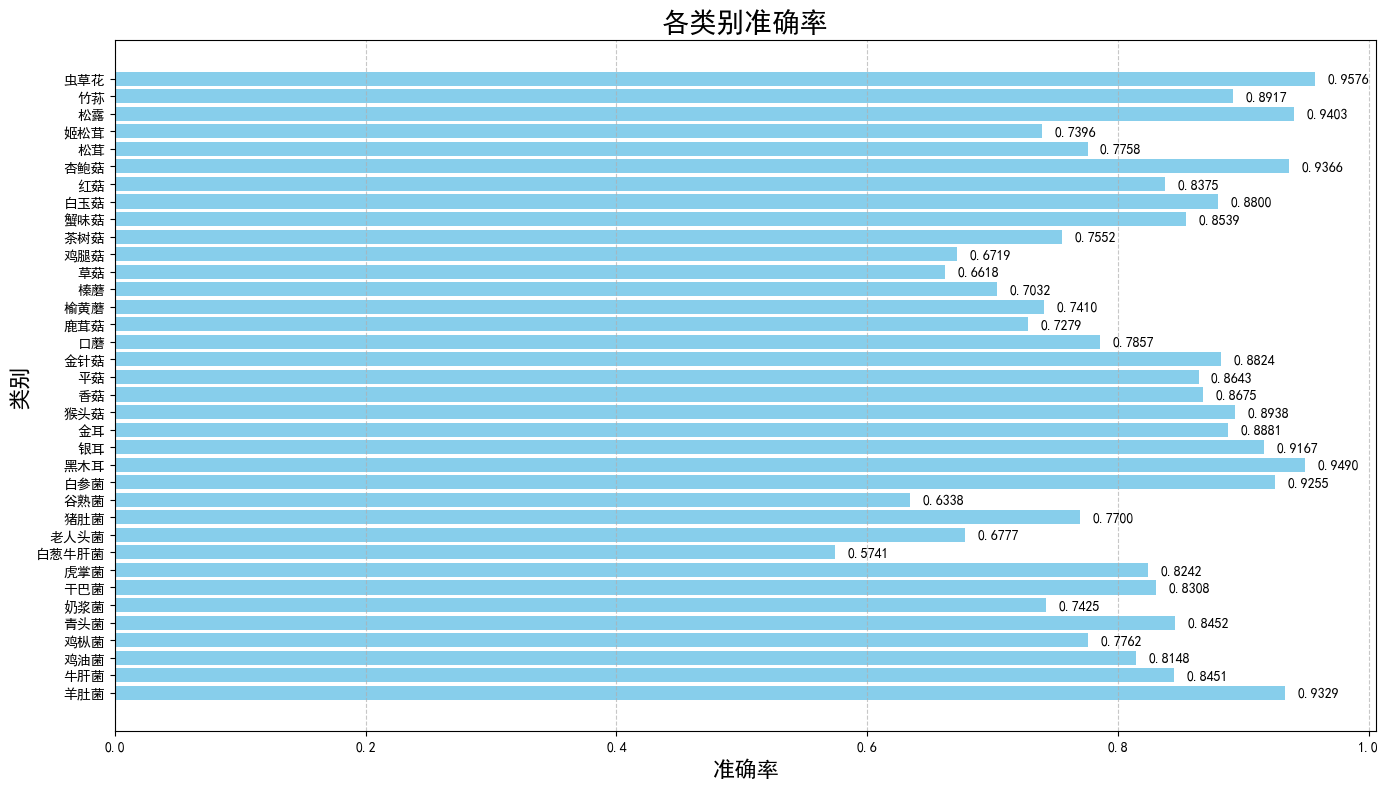

{'class00': np.float64(0.9328859060402684),
 'class01': np.float64(0.8450704225352113),
 'class02': np.float64(0.8148148148148148),
 'class03': np.float64(0.7762237762237763),
 'class04': np.float64(0.8451612903225807),
 'class05': np.float64(0.7425149700598802),
 'class06': np.float64(0.8307692307692308),
 'class07': np.float64(0.8242424242424242),
 'class08': np.float64(0.5740740740740741),
 'class09': np.float64(0.6776859504132231),
 'class10': np.float64(0.77),
 'class11': np.float64(0.6338028169014085),
 'class12': np.float64(0.9254658385093167),
 'class13': np.float64(0.9490445859872612),
 'class14': np.float64(0.9166666666666666),
 'class15': np.float64(0.8881118881118881),
 'class16': np.float64(0.89375),
 'class17': np.float64(0.8675496688741722),
 'class18': np.float64(0.8642857142857143),
 'class19': np.float64(0.8823529411764706),
 'class20': np.float64(0.7857142857142857),
 'class21': np.float64(0.7279411764705882),
 'class22': np.float64(0.7409638554216867),
 'class23': n

In [58]:
# 计算并打印每个类别的准确率
calculate_class_accuracies(MobileNet, train_dataset)

In [ ]:
convert = tf.lite.TFLiteConverter.from_keras_model(MobileNet)
MobileNet_tflite = convert.convert()

with open("MobileNetV1.tflite", "wb") as f:
  f.write(MobileNet_tflite)

# MobileNetV2模型

In [ ]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
MobileNetV2 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
MobileNetV2.summary()

In [ ]:
# Train the model
MobileNetV2_history = MobileNetV2.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


In [ ]:
show_history(MobileNetV2_history)

In [ ]:
convert = tf.lite.TFLiteConverter.from_keras_model(MobileNetV2)
MobileNetV2_tflite = convert.convert()

with open("MobileNetV2.tflite", "wb") as f:
  f.write(MobileNetV2_tflite)

# EfficientNet模型

In [ ]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.efficientnet.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
EfficientNetB0 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
EfficientNetB0.summary()

In [ ]:
# Train the model
EfficientNetB0_history = EfficientNetB0.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


In [ ]:
show_history(EfficientNetB0_history)

In [ ]:
convert = tf.lite.TFLiteConverter.from_keras_model(EfficientNetB0)
EfficientNetB0_tflite = convert.convert()

with open("EfficientNetB0.tflite", "wb") as f:
  f.write(EfficientNetB0_tflite)

# ResNet模型

In [ ]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.ResNet101(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.resnet.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
ResNet101 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
ResNet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
ResNet101.summary()

In [ ]:
# Train the model
ResNet101_history = ResNet101.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


In [ ]:
show_history(ResNet101_history)

In [ ]:
calculate_class_accuracies(ResNet101, train_dataset)

In [ ]:
convert = tf.lite.TFLiteConverter.from_keras_model(ResNet101)
ResNet101_tflite = convert.convert()

with open("ResNet101.tflite", "wb") as f:
  f.write(ResNet101_tflite)